<a href="https://colab.research.google.com/github/GrueneKatze/AI-for-Medicine-Coursera/blob/master/Pneumonia_detection_with_FastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import os

In [0]:
!pip install -q pydicom

In [4]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as pydicom
#%matplotlib inline 



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import imageio
import PIL
import json, pdb

In [0]:
import zipfile


In [0]:
#path_vi = path_v/'mdai_rsna_project_x9N20BZa_images_2018-07-20-153330'
#path_vi.ls()

In [6]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai/'

Mounted at /content/gdrive


In [0]:
path_f = Path(base_dir)

In [0]:
path_rsna = Path(base_dir + 'rsna')
path_rsna.mkdir(parents=True, exist_ok=True)
#path_rsna.ls()

In [0]:
path_train = Path(base_dir + 'rsna/train')
path_train.mkdir(parents=True, exist_ok=True)

In [0]:
path_v = Path(base_dir + 'rsna/valida')
path_v.mkdir(parents=True, exist_ok=True)
#path_v.ls()

In [0]:
path_f.ls()

[PosixPath('/content/gdrive/My Drive/fastai/stage_2_detailed_class_info.csv.zip'),
 PosixPath('/content/gdrive/My Drive/fastai/stage_2_train_images.zip'),
 PosixPath('/content/gdrive/My Drive/fastai/stage_2_train_labels.csv.zip'),
 PosixPath('/content/gdrive/My Drive/fastai/rsna'),
 PosixPath('/content/gdrive/My Drive/fastai/data')]

In [0]:
#with zipfile.ZipFile(path_f/'stage_2_detailed_class_info.csv.zip', 'r') as zip_ref:
 # zip_ref.extractall(path_rsna)
#with zipfile.ZipFile(path_f/'stage_2_train_labels.csv.zip', 'r') as zip_ref:
  #zip_ref.extractall(path_rsna)
#with zipfile.ZipFile(path_f/'stage_2_train_images.zip', 'r') as zip_ref:
  #zip_ref.extractall(path_train)  

In [0]:
path_m = Path(base_dir + 'rsna/models')
path_m.mkdir(parents=True, exist_ok=True)

In [0]:
#Creating list of file names for validation
#path_images
fnames = get_files(path_train,extensions=['.dcm'],recurse=recurse)#(path_images)get_files
files = fnames[0:300]

26384

In [0]:
#to del

#os.path.splitext(os.path.basename(fnames[100]))[0]

#fnames_wo_path = [os.path.splitext(os.path.basename(fnames[i]))[0] for i in fnames]
#os.path.splitext(os.path.basename(fnames[0]))[0]
#len('0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm')

In [0]:
#Creating validation dataset
#files = os.listdir(path_train)
source = '/content/gdrive/My Drive/fastai/rsna/train/'
dest1 = '/content/gdrive/My Drive/fastai/rsna/valida/'
for f in files:
  shutil.move(source+f, dest1)
#Path(base_dir + 'rsna/train/')
#source.mkdir(parents=True, exist_ok=True)#path_train



100

In [0]:
#Chacking amount of files for validation
dest1 = '/content/gdrive/My Drive/fastai/rsna/valida/'

fs = os.listdir(dest1)

len(fs)

300

In [0]:
fs[0:3]

['f5b6bfda-91a9-49e3-8d26-1a71d774e515.dcm',
 'f5b9e64c-e373-4ccb-806c-850c5a38dad6.dcm',
 'f5ba9837-2483-4663-8472-2961beaddd18.dcm']

In [0]:
#Creating list of image IDs to split training and validation labels
image_ids = []
for i in fs:
  n = i[:-4]
  image_ids.append(n)

In [0]:
len(image_ids)

300

In [0]:
#From the labels csv file remove raws with patientIDs being equal to image_ids
train_labels_df = pd.read_csv(path_rsna/'stage_2_train_labels.csv')

In [0]:
train_labels_df[train_labels_df['patientId']=='f5b6bfda-91a9-49e3-8d26-1a71d774e515']

#image_ids = []
#for i in vals:
 # n = i.stem
  #image_ids.append(n)
#image_ids

,patientId,x,y,width,height,Target
27686,f5b6bfda-91a9-49e3-8d26-1a71d774e515,NaN,NaN,NaN,NaN,0


In [0]:
train_labels_df.shape

(30227, 6)

In [0]:
valid_labels_df = pd.DataFrame(columns=train_labels_df.columns)

In [0]:
#train_labels_df.patientId.all() in image_ids
#cond = df1.A < 1

False

In [0]:
for i in image_ids:
  #if i == train_labels_df.patientId:
  rows = train_labels_df.loc[train_labels_df['patientId'] == i, :]
  valid_labels_df = valid_labels_df.append(rows, ignore_index=False)
  train_labels_df.drop(rows.index, inplace=True)


In [0]:
valid_labels_df

,patientId,x,y,width,height,Target
27686,f5b6bfda-91a9-49e3-8d26-1a71d774e515,NaN,NaN,NaN,NaN,0
27687,f5b9e64c-e373-4ccb-806c-850c5a38dad6,705.0,556.0,167.0,247.0,1
27688,f5ba9837-2483-4663-8472-2961beaddd18,NaN,NaN,NaN,NaN,0
27689,f5ba9b65-ab27-4b62-a451-bd60c45f9203,NaN,NaN,NaN,NaN,0
27690,f5bb54ee-a4a0-49d6-be55-5687176002f4,268.0,189.0,211.0,256.0,1
...,...,...,...,...,...,...
28131,f961ffa3-2df5-48ce-854a-1440df7f7a6e,174.0,202.0,205.0,328.0,1
28132,f96219c6-014a-4386-bc58-ed27333089ed,NaN,NaN,NaN,NaN,0
28133,f9632d11-8abe-4cee-bda5-6586bfb8e8e6,NaN,NaN,NaN,NaN,0
28134,f9651c64-a88f-46fd-9ca1-63a55f50873c,164.0,306.0,212.0,308.0,1


In [0]:
#Checking training dataset for presence of images that have to be removed

In [0]:
train_labels_df[train_labels_df['patientId']=='f9651c64-a88f-46fd-9ca1-63a55f50873c']

,patientId,x,y,width,height,Target


In [0]:
train_labels_df.to_csv(path_train/'train_labels.csv')
valid_labels_df.to_csv(path_v/'val_labels.csv')

In [0]:
train_labels_df = pd.read_csv(path_train/'train_labels.csv')


In [0]:
valid_labels_df = pd.read_csv(path_v/'val_labels.csv')

##Exploring & preprocessing data



In [0]:
#train_labels_df = pd.read_csv(path_rsna/'stage_2_train_labels.csv')

In [14]:
print(f"Train labels -  rows: {train_labels_df.shape[0]}, columns: {train_labels_df.shape[1]}")

Train labels -  rows: 29892, columns: 7


In [0]:
train_labels_df.sample(10)

,Unnamed: 0,patientId,x,y,width,height,Target
7875,7875,5aacbb2b-e0aa-4ddd-8cd1-732d2fefbf48,NaN,NaN,NaN,NaN,0
15351,15351,96156752-6bc8-48cb-8553-34cabcc5becc,NaN,NaN,NaN,NaN,0
11760,11760,7970b714-abe9-44e3-a10a-223c15f24753,208.0,385.0,226.0,230.0,1
5969,5969,4b26d000-be82-4426-80f6-d129ff2e8c7c,226.0,125.0,209.0,590.0,1
28862,29197,0e240e03-8d4e-4415-a2e1-03ec36b15bfc,NaN,NaN,NaN,NaN,0
8785,8785,625f8968-3135-4c81-a5a5-aa61dab240c7,NaN,NaN,NaN,NaN,0
17355,17355,a60ef587-cac7-485a-a97f-c93f9d11e57e,NaN,NaN,NaN,NaN,0
20102,20102,b915ae1a-346d-4e9f-b1fd-a72e0a78a864,683.0,316.0,253.0,331.0,1
249,249,06415658-2590-4c38-a682-81acf9ef9a14,NaN,NaN,NaN,NaN,0
24716,24716,ddfcc1a2-9c25-44c8-9b00-c927c1f2369e,NaN,NaN,NaN,NaN,0


In [0]:
valid_labels_df.head(10)

,Unnamed: 0,patientId,x,y,width,height,Target
0,27686,f5b6bfda-91a9-49e3-8d26-1a71d774e515,NaN,NaN,NaN,NaN,0
1,27687,f5b9e64c-e373-4ccb-806c-850c5a38dad6,705.0,556.0,167.0,247.0,1
2,27688,f5ba9837-2483-4663-8472-2961beaddd18,NaN,NaN,NaN,NaN,0
3,27689,f5ba9b65-ab27-4b62-a451-bd60c45f9203,NaN,NaN,NaN,NaN,0
4,27690,f5bb54ee-a4a0-49d6-be55-5687176002f4,268.0,189.0,211.0,256.0,1
5,27691,f5bb54ee-a4a0-49d6-be55-5687176002f4,221.0,502.0,169.0,237.0,1
6,27692,f5c2a165-7210-4db1-b467-1e30cbd606fd,NaN,NaN,NaN,NaN,0
7,27693,f5c357e1-82e8-46bc-8b8d-ab4d57788aa4,NaN,NaN,NaN,NaN,0
8,27694,f5c855dd-5275-4646-9cda-7ed7288f0ea0,NaN,NaN,NaN,NaN,0
9,27695,f5c8c054-78a6-4085-8028-7bb635dc6122,NaN,NaN,NaN,NaN,0


In [0]:
#Move to fin
class_info_df = pd.read_csv(path_rsna/'stage_2_detailed_class_info.csv')

In [0]:
#Move to fin
class_info_df.sample(10)

,patientId,class
10663,71041150-5565-445f-9211-d1e42bc8dde5,No Lung Opacity / Not Normal
24419,db750e84-7776-440f-a985-84f5fbfd010b,Normal
6144,4c763e47-7d5a-43f0-a072-1a292807b260,No Lung Opacity / Not Normal
24590,dceeb019-ae9d-4426-8b42-38aedd4f385d,Normal
1076,0c860336-135a-4eed-9269-105f65dc9a4d,No Lung Opacity / Not Normal
28681,fda9946c-adac-4be9-a57d-c1ee75887c3c,No Lung Opacity / Not Normal
9548,6850e324-6105-4e8e-961e-6ae2f5e71e66,Normal
8153,5d1c02ee-d8be-411e-b89b-f7175833204b,No Lung Opacity / Not Normal
10978,7338e55e-45f1-456a-bf21-73381ab1ef36,No Lung Opacity / Not Normal
30048,2e4e8d73-c213-47f2-a4f4-cebe3a6b2467,Normal


In [0]:
#Move to fin
class_info_df.isnull().any()

patientId    False
class        False
dtype: bool

In [0]:
#Move to fin
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

In [0]:
#Move to fin
train_class_df['path'] = 
for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(path,"stage_2_train_images/",patientImage)
#train_class_df.apply(lambda row: path_images/ +train_class_df['patientId']+'.dcm', axis=1)
#str(path_images/ + train_class_df['patientId']+'.dcm')
#train_class_df['path'].map(lambda x: x.replace('input', path_images/ + train_class_df['patientId']+'.dcm'))

In [0]:
#Move to fin
#convert class data into one-hot encoding format
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
class_enc = LabelEncoder()
train_class_df['class_idx'] = class_enc.fit_transform(train_class_df['class'])
oh_enc = OneHotEncoder(sparse=False)
train_class_df['class_vec'] = oh_enc.fit_transform(train_class_df['class_idx'].values.reshape(-1, 1)).tolist() 
train_class_df.sample(3)

,patientId,x,y,width,height,Target,class,class_idx,class_vec
24033,b33610c9-a152-47f8-8ee5-4f81dce62938,197.0,358.0,259.0,333.0,1,Lung Opacity,0,"[1.0, 0.0, 0.0]"
3040,2e826ff4-4329-4b2b-9467-c4506ab1f6ba,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]"
23850,b2541f48-1acf-4f33-b604-8665fc1517c8,179.0,581.0,169.0,183.0,1,Lung Opacity,0,"[1.0, 0.0, 0.0]"


In [0]:
#Move to fin
#split to train and val sets
#from sklearn.model_selection import train_test_split
#image_df = train_class_df.groupby('patientId').apply(lambda x: x.sample(1))
#raw_train_df, valid_df = train_test_split(image_df, test_size=0.25, random_state=2018,
#                                    stratify=image_df['class'])
#print(raw_train_df.shape, 'training data')
#print(valid_df.shape, 'validation data')

(20013, 7) training data
(6671, 7) validation data


In [0]:
#Move to fin
#fastai option to split data

data = (ImageList.from_df(labels[['file', 'label']].dropna(), path)
           .split_by_rand_pct(0.2)
           .label_from_df(label_delim=';')
           .transform(tfms, size=128)
           .databunch())

In [0]:
def open_dcm_image(fn:PathOrStr,convert_mode:str='RGB',after_open:Callable=None)->Image:
  "Return `Image` object created from image in file `fn`."
  array = pydicom.dcmread(fn).pixel_array
  x = PIL.Image.fromarray(array).convert('RGB')
  return Image(pil2tensor(x,np.float32).div_(255))

In [0]:
vision.data.open_image = open_dcm_image

In [17]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0)
# Creating Image DataBunch
data = ImageDataBunch.from_csv(path_rsna,folder='train',csv_labels='train_labels.csv',ds_tfms=tfms,fn_col='patientId',label_col='Target',suffix='.dcm',seed=47,size=224)
#data = ImageDataBunch.from_csv(path_rsna,folder='images',csv_labels='stage_2_train_labels.csv',fn_col='patientId',label_col='Target',suffix='.dcm',seed=47,size=224)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


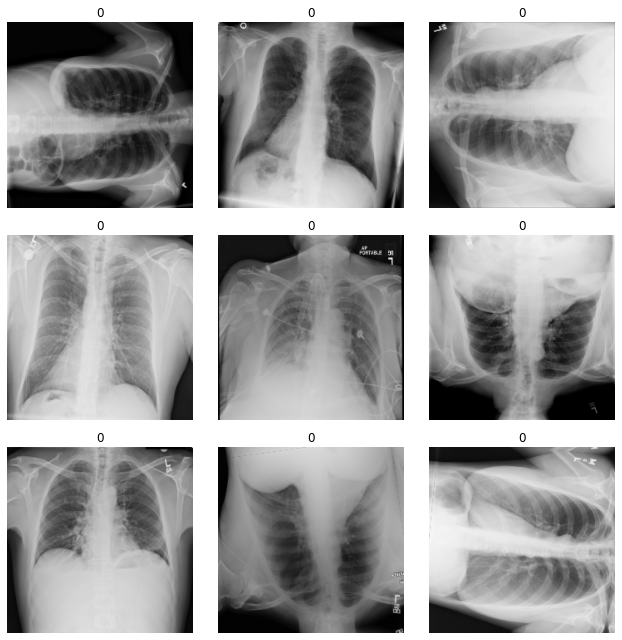

In [0]:
data.show_batch(rows=3, figsize=(9,9))

##Defining model

In [18]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy,error_rate])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn.fit_one_cycle(2)

In [0]:
learn.save(path_m/'1a')

In [0]:
learn.load(path_m/'1a')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Learner(data=ImageDataBunch;

Train: LabelList (23914 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,1
Path: /content/gdrive/My Drive/fastai/rsna;

Valid: LabelList (5978 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,0,0,0
Path: /content/gdrive/My Drive/fastai/rsna;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [0]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.460638,0.443942,0.791235,0.208765,2:31:47
1,0.420035,0.401980,0.814152,0.185848,18:02
2,0.406691,0.385944,0.822181,0.177819,17:47


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

In [0]:
learn.save(path_m/'1b')

In [0]:
learn.load(path_m/'1b')

In [0]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.429550,0.392945,0.816996,0.183004,1:06:48
1,0.408661,0.385814,0.822014,0.177986,18:42
2,0.400659,0.380968,0.821847,0.178153,18:39


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

In [0]:
learn.save(path_m/'1c')

In [0]:
learn.load(path_m/'1c')

In [0]:
#learn.unfreeze()

In [20]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


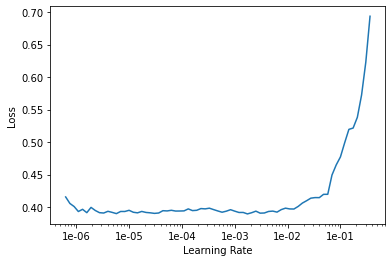

In [21]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10, max_lr=slice(3e-4, 3e-3))#learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,error_rate,time


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

In [0]:
learn.save(path_m/'2a')

##To delete

In [0]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(path,"stage_2_train_images/",patientImage)
        data_row_img_data = pydicom.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = pydicom.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = train_class_df[train_class_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="yellow",alpha = 0.1))   
    plt.show()

    #show_dicom_images_with_boxes(train_class_df[train_class_df['Target']==1].sample(9))

In [0]:
import pydicom
import pylab

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

In [0]:
!pip install tensorflow-io

In [0]:
import tensorflow_io as tfio

In [0]:
#https://www.kaggle.com/search?q=pneumonia+detection+in%3Anotebooks
#https://www.kaggle.com/natevegh/pneumonia-detection-98-acc-fastai-2019-update
#https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

In [0]:
import zipfile

Mounted at /content/gdrive


In [0]:
path_try = Path(base_dir + 'data/rsna/try')
path_try.mkdir(parents=True, exist_ok=True)

In [0]:
path_test = Path(base_dir + 'data/rsna/test')
#for folder in folders:
#path = Path(base_dir + 'rsna/test')
#dest = path/folder
path_test.mkdir(parents=True, exist_ok=True)

In [0]:
path_images = Path(base_dir + 'data/rsna/images')
path_images.mkdir(parents=True, exist_ok=True)

In [0]:
path = Path(base_dir + 'data/rsna')
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/.ipynb_checkpoints'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/stage_2_train_images.zip'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/stage_2_test_images.zip'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/stage_2_train_labels.csv.zip'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/test'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/try'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/images')]

In [0]:
#works, unzips files in Colab only
#path to one of the files unzipped /content/gdrive/My Drive/fastai-v3/data/rsna/test/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm
with zipfile.ZipFile(path/'stage_2_train_images.zip', 'r') as zip_ref:

  zip_ref.extractall(path_images)

In [0]:
with zipfile.ZipFile(path/'stage_2_train_labels.csv.zip', 'r') as zip_ref:

  zip_ref.extractall(path_try)

In [0]:
test_predictions = np.array([0.8, 0.8, 0.4, 0.6, 0.3])
th = 0.5
d = test_predictions > th
d

array([ True,  True, False,  True, False])

### Exploring data

In [0]:
len(os.listdir(path_images))

26684

In [0]:
os.listdir(path_images)[2]

'f79fc759-fde0-4e2e-8951-26ac8af5ef89.dcm'

In [0]:
len(os.listdir(path_test))

3000

In [0]:
os.listdir(path_test)[0]

'260b87ff-df13-4177-90bb-53fb0618b1db.dcm'

In [0]:
fname = os.listdir(path_images)[0]
path_images/fname

PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/images/f79e5a75-5e15-431a-9ba3-de64c1724b65.dcm')

In [0]:
filename = '/content/gdrive/My Drive/fastai-v3/data/rsna/images/f79e5a75-5e15-431a-9ba3-de64c1724b65.dcm'#path_images/fname#'/content/gdrive/My Drive/fastai-v3/data/rsna/test/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm'
image_bytes = tf.io.read_file(filename)

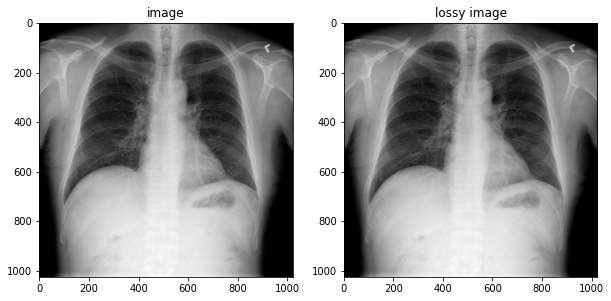

In [0]:


image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)

skipped = tfio.image.decode_dicom_image(image_bytes, on_error='skip', dtype=tf.uint8)

lossy_image = tfio.image.decode_dicom_image(image_bytes, scale='auto', on_error='lossy', dtype=tf.uint8)


fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(np.squeeze(image.numpy()), cmap='gray')
axes[0].set_title('image')
axes[1].imshow(np.squeeze(lossy_image.numpy()), cmap='gray')
axes[1].set_title('lossy image');

In [0]:
tfms = get_transforms()

In [0]:
np.random.seed(7)
data = ImageDataBunch.from_folder(path_images, size=256, bs=bs, ds_tfms=tfms).normalize(imagenet_stats) #valid='val', valid_pct=0.2,
                                  

IndexError: ignored

In [0]:
len(os.listdir(path_images))

26684

In [0]:
os.listdir(path_images)[0:10]

['f79e5a75-5e15-431a-9ba3-de64c1724b65.dcm',
 'f79fa94e-8886-425c-95d4-81abfea92aee.dcm',
 'f79fc759-fde0-4e2e-8951-26ac8af5ef89.dcm',
 'f7a169e2-a1a7-439a-ab83-0d34cf5ae4b9.dcm',
 'f7a172fc-a34f-4155-806d-7b0afe2a6156.dcm',
 'f7a1de8c-7802-4af3-98c4-4dfb088b986d.dcm',
 'f7a37b72-fda5-4adc-b3b0-968c923bc1c6.dcm',
 'f7a42b73-f909-4e1f-89dd-c776f45cdc40.dcm',
 'f7a488d3-34b2-4bcf-b61a-b4ad12c230e0.dcm',
 'f7a5fd29-dd8d-4f85-8164-69b2e83da35e.dcm']

ERROR! Session/line number was not unique in database. History logging moved to new session 59
     |████████████████████████████████| 35.3MB 99kB/s 


In [0]:
#https://www.kaggle.com/gpreda/rsna-pneumonia-detection-eda
#https://colab.research.google.com/drive/1reOc-bBi2CNBZ94rHsy86dMJbm9KwJGU
data_row_img = pydicom.dcmread(imagePath)

In [0]:
ds=pydicom.read_file(path_images/'0afef50e-63a7-4adf-9bc1-02f73612be56.dcm')


AttributeError: ignored

In [0]:
pylab.imshow(ds.pixel_array, cmap=pylab.cm.bone)
<matplotlib.image.AxesImage object at 0x0162A530>
pylab.show()

In [0]:
img = open_image(path_images/'0afef50e-63a7-4adf-9bc1-02f73612be56.dcm')#data/rsna/4b4d8179-7c0d-415f-bb11-5dbda89b5abe.dcm'#'val'/'NORMAL'/'NORMAL2-IM-1440-0001.jpeg')
#'/root/.fastai/data/rsna/5c26b94b-78f6-49ff-95a7-a2e4fce83778.dcm'
print(img.data.shape)
img.show()

UnidentifiedImageError: ignored

> /usr/local/lib/python3.6/dist-packages/PIL/Image.py(2862)open()
   2860         warnings.warn(message)
   2861     raise UnidentifiedImageError(
-> 2862         "cannot identify image file %r" % (filename if filename else fp)
   2863     )
   2864 

--KeyboardInterrupt--
--KeyboardInterrupt--
--KeyboardInterrupt--


In [0]:
!unzip path/stage_2_test_images.zip -d path_test

unzip:  cannot find or open path/stage_2_test_images.zip, path/stage_2_test_images.zip.zip or path/stage_2_test_images.zip.ZIP.


In [0]:
!unzip -q path/stage_2_test_images.zip -d path_test

unzip:  cannot find or open path/stage_2_test_images.zip, path/stage_2_test_images.zip.zip or path/stage_2_test_images.zip.ZIP.


In [0]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [0]:
#for data folder, works with unzipping method e.g. ! unzip -q -n {path}/stage_2_train_labels.csv.zip -d {path}
path = Config.data_path()/'rsna'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/rsna')

In [0]:
path_test = Config.data_path()/'rsna'/'test'
path_test.mkdir(parents=True, exist_ok=True)
path_test

PosixPath('/root/.fastai/data/rsna/test')

In [0]:
path_test = Path(base_dir + 'rsna/test')
#for folder in folders:
#path = Path(base_dir + 'rsna/test')
#dest = path/folder
path_test.mkdir(parents=True, exist_ok=True)

In [0]:
path = Path(base_dir + 'data/rsna')
path.mkdir(parents=True, exist_ok=True)
#dest = path/folder
#dest.mkdir(parents=True, exist_ok=True)

In [0]:
bs = 64

In [0]:
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/.ipynb_checkpoints'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/stage_2_train_labels.csv.zip'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/stage_2_train_images.zip'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/stage_2_test_images.zip')]

In [0]:
path = Path(base_dir + 'rsna')

In [0]:
os.chdir('/content/gdrive/My Drive/fastai-v3/data/rsna')

In [0]:
!unzip -q stage_2_train_labels.csv.zip -d path_test/

unzip:  cannot find or open stage_2_train_labels.csv.zip, stage_2_train_labels.csv.zip.zip or stage_2_train_labels.csv.zip.ZIP.


In [0]:
! unzip -q -n {path}/stage_2_train_labels.csv.zip -d {path_test}

unzip:  cannot find or open /content/gdrive/My, /content/gdrive/My.zip or /content/gdrive/My.ZIP.


In [0]:
! unzip -q -n {path}/stage_2_test_images.zip -d {path}

In [0]:
! unzip -q -n {path}/stage_2_train_labels.csv.zip -d {path}

In [0]:
#path = Path('../input/chest_xray/chest_xray')
#path.ls()

In [0]:
img = open_image(path/5c26b94b-78f6-49ff-95a7-a2e4fce83778.dcm)#data/rsna/4b4d8179-7c0d-415f-bb11-5dbda89b5abe.dcm'#'val'/'NORMAL'/'NORMAL2-IM-1440-0001.jpeg')
#'/root/.fastai/data/rsna/5c26b94b-78f6-49ff-95a7-a2e4fce83778.dcm'
print(img.data.shape)
img.show()

SyntaxError: ignored